# Machine Learning Lab on Linear Classification and Logistic Regression

In this CoLab notebook we will see a concrete classification problem solved with Linear Classification (LC) and Logistic Regression (LR). You have to implement some functions in order to complete and see all the results.

The pipeline of the notebook is as follows:

* Load the dataset for classification,
* Pre-process the dataset,
* Implement a LC model, in particular:
    * Model prediction function,
    * Mean Squared Error (MSE) loss for the model,
    * MSE gradient for gradient descent,
    * Gradient descent for model optimization,
    * Model evaluation and plot of decision boundary,
* Implement a LR model, in particular:
    * Model prediction function,
    * Cross Entropy (CE) loss for the model,
    * CE gradient for gradient descent,
    * Gradient descent for model optimization,
    * Model evaluation and plot of decision boundary,

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Check function. Used for checking your code, you can ignore this.
def check_func(func, *args):
    res = {
        'sigmoid': np.array([4.5397868702434395e-05, 0.0066928509242848554, 
                   0.11920292202211755, 0.5, 0.8807970779778823, 
                   0.9933071490757153, 0.9999546021312976]).reshape(-1, 1),
        'xent': [1.3758919771597742, 0.8487364948617685, 0.8616020843171404, 
                    1.2847647859647024, 1.0979517701821886, 1.2448204497955682, 
                    1.148747135298692, 0.9142123727250151, 0.9503784164146648, 
                    0.5259295090148516],
        'gradient': [0.05517542101762578, 0.056956027283867096, 
                     0.10246057091641199, 0.1729957759994022, 
                     -0.07420252599770667, -0.10440419638201064, 
                     0.0814283804697549, -0.1722842404987195, 
                     0.16445779692602908, -0.0962341984706773],
        'predict_lc': [1., -1., 1., 1., -1., -1., 1., 1., -1., 1.],
        'predict_lr': [1., 0., 1., 1., 0., 0., 1., 1., 0., 1.],
        'mse': [0.20665046013997404, 0.12503917069875575, 0.15871653661209398,
                0.24302395420833073, 0.19655530689347242, 0.19455858448384966,
                0.2078562677711177, 0.1626431893970271, 0.12018726319497597, 
                0.0969268504978511]
    }
    with open('./ex2data1.txt', 'r') as txt:
        y = np.array([[float(line.strip().split(',')[2])] 
                      for line in txt.readlines()], dtype=np.float32)
    res['evaluate_lr'] = [y]
    res['evaluate_lc'] = [np.array([-1 if y_i < 0.5 else 1 for y_i in y.reshape(-1)], dtype=np.float32).reshape(-1, 1)]
    print('CHECK RESULTS:')
    print('\n' + ''.join(['=' for _ in range(40)]))
    are_correct = []
    for idx, y in enumerate(res[func.__name__]):
        arg = [a[idx] for a in args]
        y_ = func(*arg)
        if func.__name__ == 'evaluate_lr':
            acc = (1.0 * (y_ == y)).mean()
            y_, y = acc, 0.88
            are_correct += [f'{y_:.4f}' > f'{y:.4f}']
            print(f'Your train accuracy: {100 * y_:.2f}%, Expected train accuracy: > {100 * y:.2f}%')
        elif func.__name__ == 'evaluate_lc':
            acc = (1.0 * (y_ == y)).mean()
            y_, y = acc, 0.88
            are_correct += [f'{y_:.4f}' > f'{y:.4f}']
            print(f'Your train accuracy: {100 * y_:.2f}%, Expected train accuracy: > {100 * y:.2f}%')
        else:
            if isinstance(y_, np.ndarray):
                y_ = y_.reshape(-1)[0]
            if isinstance(y, np.ndarray):
                y = y.reshape(-1)[0]
            are_correct += [f'{y_:.4f}' == f'{y:.4f}']
            print(f'Your result: {y_:.4f}, Expected: {y:.4f}')
    print('\n' + ''.join(['=' for _ in range(40)]))
    if all(are_correct):
        print('Function is correct! Well done!'.upper())
    else:
        print('Function is not correct. Find the bug.')

# Dataset

You will build a linear classification and a logistic regression model to predict whether a student gets admitted into a university.
Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for your model. For each training example, you have the applicant’s scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant’s probability of admission based the scores from those two exams.

In [ ]:
# Load the dataset
x, y = [], []
with open('./ex2data1.txt', 'r') as txt:
    for line in txt.readlines():
        vals = line.strip().split(',')
        x += [[float(vals[0]), float(vals[1])]]
        y += [[float(vals[2])]]
x_raw = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)
y_lc = np.array([-1 if y_i < 0.5 else 1 for y_i in y], dtype=np.float32).reshape(-1, 1)

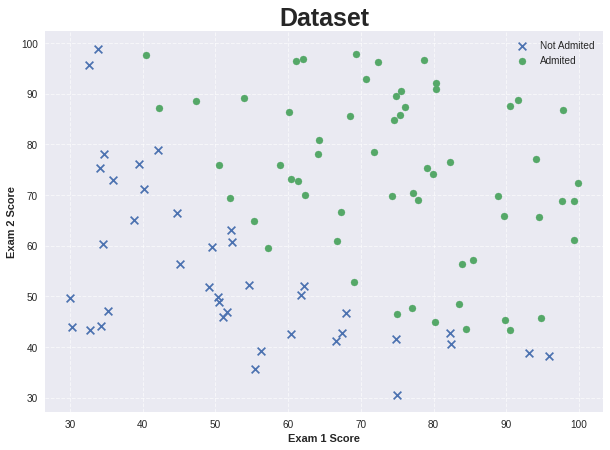

In [ ]:
# Plot the dataset
plt.figure(figsize=(10, 7))
plt.title('Dataset', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y[i] == 0], 
            label='Not Admited', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            label='Admited')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('Exam 1 Score', fontweight='bold')
plt.ylabel('Exam 2 Score', fontweight='bold')
plt.legend()
plt.show()

## Preprocess the dataset

* **Normalization**: in this way our dataset has zero mean and unit standard deviation (important for the optimization step)

$$x_i \leftarrow \frac{x_i - \mu_x}{\sigma_x} \ \ \forall i$$

* **Append $1$ to $x$**: in this way we include the bias in the parameter vector

$$x_i \leftarrow [x_i, 1]  \ \ \forall i$$

In [ ]:
# Normalize the dataset
x_mu, x_std = x_raw.mean(axis=0), x_raw.std(axis=0)
x = (x_raw - x_mu) / x_std

# Append ones column
x = np.concatenate([x, np.ones([len(x), 1], dtype=np.float32)], axis=-1)

## Linear Classification Model

Given a data point $x \in \mathbb{R}^{3}$ (extended with a 1 on its last component) and a parameter vector $\theta \in \mathbf{R}^3$ the linear classification model makes predictions as follows:

$$h_{\theta} = \theta^Tx$$

$$y = sign(h_{\theta}) = sign(\theta^Tx)$$

In [ ]:
def predict_lc(x, theta):
    '''
    input x: np.ndarray of shape (m, 3)
    input theta: np.ndarray of shape (3, 1)
    output y: np.ndarray of shape (m, 1)
    '''
    pass

# Check function
np.random.seed(1234)
_x = np.random.uniform(-1, 1, size=(10, 10, 3))
_theta = np.random.uniform(-1, 1, size=(10, 3, 1))
check_func(predict_lc, _x, _theta)

CHECK RESULTS:

Your result: 1.0000, Expected: 1.0000
Your result: -1.0000, Expected: -1.0000
Your result: 1.0000, Expected: 1.0000
Your result: 1.0000, Expected: 1.0000
Your result: -1.0000, Expected: -1.0000
Your result: -1.0000, Expected: -1.0000
Your result: 1.0000, Expected: 1.0000
Your result: 1.0000, Expected: 1.0000
Your result: -1.0000, Expected: -1.0000
Your result: 1.0000, Expected: 1.0000

FUNCTION IS CORRECT! WELL DONE!


## Mean squared error loss

$$J(\theta) = \frac{1}{2m}\sum_{i=1}^m \left(y^{(i)} - h_{\theta}(x^{(i)}) \right)^2$$

In [ ]:
def mse(y_true, y_pred):
    '''
    input y_true: np.ndarray of shape (m, 1)
    input y_pred: np.ndarray of shape (m, 1)
    output J: float
    '''
    # Insert your code here ~ 1-3 lines
    pass

# Check function
np.random.seed(1234)
y_true = np.random.randint(2, size=(10, 10))
y_pred = np.random.uniform(0, 1, size=(10, 10))
check_func(mse, y_true, y_pred)

CHECK RESULTS:

Your result: 0.2067, Expected: 0.2067
Your result: 0.1250, Expected: 0.1250
Your result: 0.1587, Expected: 0.1587
Your result: 0.2430, Expected: 0.2430
Your result: 0.1966, Expected: 0.1966
Your result: 0.1946, Expected: 0.1946
Your result: 0.2079, Expected: 0.2079
Your result: 0.1626, Expected: 0.1626
Your result: 0.1202, Expected: 0.1202
Your result: 0.0969, Expected: 0.0969

FUNCTION IS CORRECT! WELL DONE!


## Gradient of the cost function

$$\frac{\partial J(\theta)}{\partial \theta_j} 
= \frac{1}{m}\sum_{i=1}^m (h_{\theta}(x^{(i)}) - y^{(i)}) x_j^{(i)} = \frac{1}{m} (\mathbf{h} - \mathbf{y}) ^T \mathbf{x}_j$$

$$\frac{\partial J(\theta)}{\partial \theta} = \Big[\frac{\partial J(\theta)}{\partial \theta_1}, \dots, \frac{\partial J(\theta)}{\partial \theta_m} \Big]^T = \frac{1}{m} (\mathbf{h} - \mathbf{y}) ^T \mathbf{x}$$

In [ ]:
def gradient(y_true, y_pred, x):
    '''
    input y_true: np.ndarray of shape (m,)
    input y_pred: np.ndarray of shape (m,)
    input x: np.ndarray of shape (m, 3)
    output dJ: np.array of shape (3, 1)
    '''
    # Reshape arrays
    y_true = y_true.reshape(-1, 1) # now shape (m, 1)
    y_pred = y_pred.reshape(-1, 1) # now shape (m, 1)

    # Your code here ~ 1-6 lines
    pass

# Check function
np.random.seed(1234)
y_true = np.random.randint(2, size=(10, 10))
y_pred = np.random.uniform(0, 1, size=(10, 10))
x_in = np.random.uniform(0, 1, size=(10, 10, 1))
check_func(gradient, y_true, y_pred, x_in)

CHECK RESULTS:

Your result: 0.0552, Expected: 0.0552
Your result: 0.0570, Expected: 0.0570
Your result: 0.1025, Expected: 0.1025
Your result: 0.1730, Expected: 0.1730
Your result: -0.0742, Expected: -0.0742
Your result: -0.1044, Expected: -0.1044
Your result: 0.0814, Expected: 0.0814
Your result: -0.1723, Expected: -0.1723
Your result: 0.1645, Expected: 0.1645
Your result: -0.0962, Expected: -0.0962

FUNCTION IS CORRECT! WELL DONE!


# Optimize Linear Classification with Gradient Descent

In [ ]:
def gradient_descent(x, y, activation_func, cost_func, gradient_func, 
                     epochs=400, seed=1234, lr=0.01, print_every=10):

    # Initialize theta parameters
    np.random.seed(seed)
    theta = np.random.normal(0, 0.001, size=(x.shape[1], 1)) / np.sqrt(2)

    # Iterations of gradient descent
    loss = []
    print('Training...')
    print(''.join(['=' for _ in range(40)]))
    for epoch in range(epochs + 1):
        loss_epoch = []
            
        # Model prediction
        z = x.dot(theta)
        h = activation_func(z) if activation_func is not None else z
        loss += [cost_func(y, h)]

        # Parameters update
        dJ = gradient(y, h, x)
        theta = theta - lr * dJ
          
        # Print loss info
        if epoch % print_every == 0:
            print(f'Epoch {epoch}: Loss {loss[-1]}')
        
    return theta, loss

theta_lc, loss_lc = gradient_descent(x, y_lc, activation_func=None, 
                                          cost_func=mse, 
                                          gradient_func=gradient, epochs=10000, 
                                          lr=0.001, print_every=1000)


Training...
Epoch 0: Loss 0.5000335506963385
Epoch 1000: Loss 0.23294062012915492
Epoch 2000: Loss 0.1951995953968704
Epoch 3000: Loss 0.18986587255924892
Epoch 4000: Loss 0.18911197976731656
Epoch 5000: Loss 0.18900540651963282
Epoch 6000: Loss 0.18899033894044837
Epoch 7000: Loss 0.18898820838531388
Epoch 8000: Loss 0.18898790708918578
Epoch 9000: Loss 0.1889878644760605
Epoch 10000: Loss 0.1889878584485221


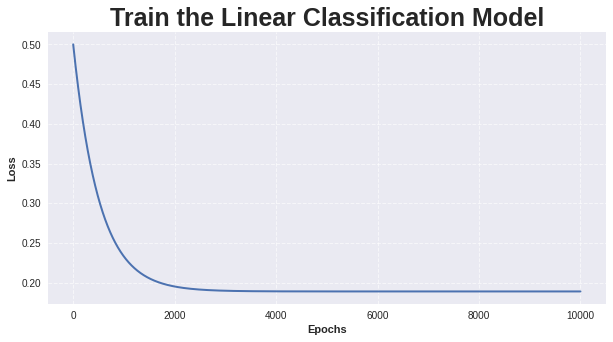

In [ ]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.title('Train the Linear Classification Model', fontweight='bold', 
          fontsize=25)
plt.plot(loss_lc, lw=2)
plt.grid(True, zorder=0, alpha=0.6, ls='--')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.show()

In [ ]:
# Evaluate Linear Classification
def evaluate_lc(x, theta, y):
    y_ = predict_lc(x, theta)
    return y_

# Check function
check_func(evaluate_lc, [x], [theta_lc], [y_lc])

CHECK RESULTS:

Your train accuracy: 90.00%, Expected train accuracy: > 88.00%

FUNCTION IS CORRECT! WELL DONE!


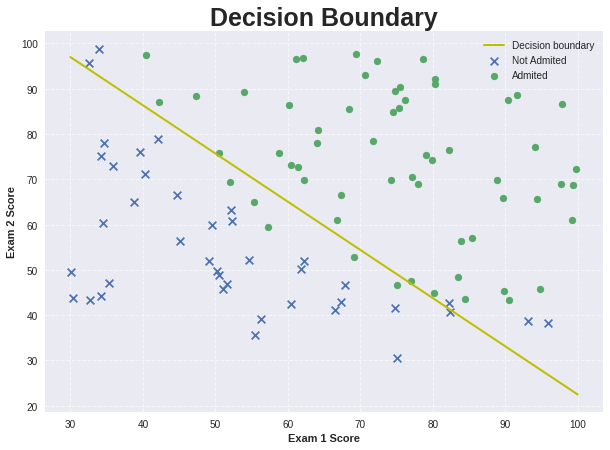

In [ ]:
# Plot decision boundary
boundary = lambda theta, x: (- theta[0] / theta[1] * (x - x_mu[0]) / x_std[0] - theta[2] / theta[1]) * x_std[1] + x_mu[1]

# Plot the dataset
plt.figure(figsize=(10, 7))
plt.title('Decision Boundary', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y_lc[i] == -1], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y_lc[i] == -1], 
            label='Not Admited', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            label='Admited')
plt.plot(np.linspace(30, 100, 100), boundary(theta_lc, np.linspace(30, 100, 100)), 
         c='y', lw=2, label='Decision boundary')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('Exam 1 Score', fontweight='bold')
plt.ylabel('Exam 2 Score', fontweight='bold')
plt.legend()
plt.show()

# Logistic Regression Model

Given a data point $x \in \mathbb{R}^{3}$ (extended with a 1 on its last component) and a parameter vector $\theta \in \mathbf{R}^3$ the logistic regression model makes predictions as follows:

$$h_{\theta}(x) = g(\theta^Tx)$$

$$g(z) = \frac{1}{1 + e^{-z}}$$

and we can decide to threshold the output $h$ at $h_{th} = 0.5$ as follows:

$$y = round(h_{\theta}(x)) = round\left(\frac{1}{1 + e^{-\theta^Tx}}\right)$$

In [ ]:
def sigmoid(z):
    '''
    input z: np.ndaray of shape (m, 3)M
    output s: np.ndarray of shape (m, 3) where s[i, j] = g(z[i, j])
    '''
    # Insert your code here ~ 1-6 line
    pass

# Check function
z = np.array([-10, -5, -2, -0, 2, 5, 10]).reshape(-1, 1)
check_func(sigmoid, z)

CHECK RESULTS:

Your result: 0.0000, Expected: 0.0000
Your result: 0.0067, Expected: 0.0067
Your result: 0.1192, Expected: 0.1192
Your result: 0.5000, Expected: 0.5000
Your result: 0.8808, Expected: 0.8808
Your result: 0.9933, Expected: 0.9933
Your result: 1.0000, Expected: 1.0000

FUNCTION IS CORRECT! WELL DONE!


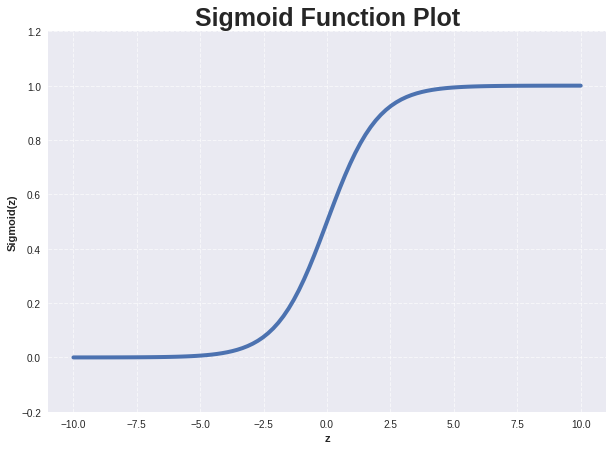

In [ ]:
# Plot sigmoid function
plt.figure(figsize=(10, 7))
plt.title('Sigmoid Function Plot', fontweight='bold', fontsize=25)
plt.plot(np.linspace(-10, 10, 100), 
         [sigmoid(z) for z in np.linspace(-10, 10, 100)], lw=4)
plt.ylim(-0.2, 1.2)
plt.grid(True, ls='--', alpha=0.6, zorder=0)
plt.xlabel('z', fontweight='bold')
plt.ylabel('Sigmoid(z)', fontweight='bold')
plt.show()

## Cross entropy loss function 

$$J(\theta) = \frac{1}{m}\sum_{i=1}^m \left[ -y^{(i)}\log (h_{\theta}(x^{(i)})) - (1 - y^{(i)}) \log(1 - h_{\theta}(x^{(i)})) \right]$$




In [ ]:
def xent(y_true, y_pred):
    '''
    input y_true: np.ndarray of shape (m,)
    input y_pred: np.ndarray of shape (m,)
    output J: float
    '''
    # Insert your code here ~ 1-6 lines
    pass

# Check function
np.random.seed(1234)
y_true = np.random.randint(2, size=(10, 10))
y_pred = np.random.uniform(0, 1, size=(10, 10))
check_func(xent, y_true, y_pred)

CHECK RESULTS:

Your result: 1.3759, Expected: 1.3759
Your result: 0.8487, Expected: 0.8487
Your result: 0.8616, Expected: 0.8616
Your result: 1.2848, Expected: 1.2848
Your result: 1.0980, Expected: 1.0980
Your result: 1.2448, Expected: 1.2448
Your result: 1.1487, Expected: 1.1487
Your result: 0.9142, Expected: 0.9142
Your result: 0.9504, Expected: 0.9504
Your result: 0.5259, Expected: 0.5259

FUNCTION IS CORRECT! WELL DONE!


In [ ]:
def predict_lr(x, theta):
    '''
    input x: np.ndarray of shape (m,3)
    input theta: np.ndarray of shape (3,1)
    output y_pred: np.ndarray of shape (m,1)
    '''
    # Insert your code here ~ 1-3 lines
    pass

# Check function
np.random.seed(1234)
_x = np.random.uniform(-1, 1, size=(10, 10, 3))
_theta = np.random.uniform(-1, 1, size=(10, 3, 1))
check_func(predict_lr, _x, _theta)

CHECK RESULTS:

Your result: 1.0000, Expected: 1.0000
Your result: 0.0000, Expected: 0.0000
Your result: 1.0000, Expected: 1.0000
Your result: 1.0000, Expected: 1.0000
Your result: 0.0000, Expected: 0.0000
Your result: 0.0000, Expected: 0.0000
Your result: 1.0000, Expected: 1.0000
Your result: 1.0000, Expected: 1.0000
Your result: 0.0000, Expected: 0.0000
Your result: 1.0000, Expected: 1.0000

FUNCTION IS CORRECT! WELL DONE!


# Gradient Descent with Logistic Regression

In [ ]:
theta_lr, loss_lr = gradient_descent(x, y, activation_func=sigmoid, 
                                          cost_func=xent, 
                                          gradient_func=gradient, epochs=200000, 
                                          lr=0.001, print_every=10000)

Training...
Epoch 0: Loss 0.6931637234144411
Epoch 10000: Loss 0.3118583606806299
Epoch 20000: Loss 0.2624975812771486
Epoch 30000: Loss 0.24238498486362603
Epoch 40000: Loss 0.23137753535492256
Epoch 50000: Loss 0.22447013469043037
Epoch 60000: Loss 0.2197773597015642
Epoch 70000: Loss 0.2164189815596496
Epoch 80000: Loss 0.21392562095487777
Epoch 90000: Loss 0.21202315395026436
Epoch 100000: Loss 0.2105405230756242
Epoch 110000: Loss 0.20936546372515213
Epoch 120000: Loss 0.20842131453289753
Epoch 130000: Loss 0.20765402316052417
Epoch 140000: Loss 0.20702446055249107
Epoch 150000: Loss 0.20650366899691008
Epoch 160000: Loss 0.20606981331932134
Epoch 170000: Loss 0.20570616244096557
Epoch 180000: Loss 0.2053997165926378
Epoch 190000: Loss 0.2051402515662577
Epoch 200000: Loss 0.20491963954562828


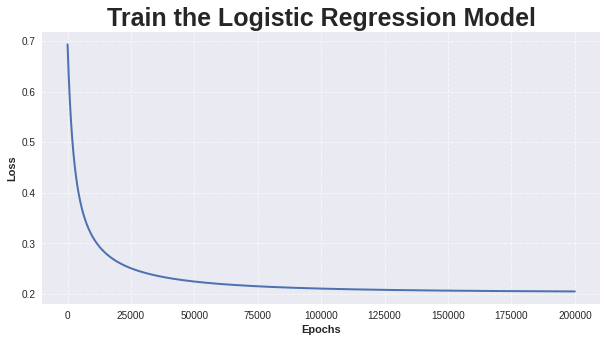

In [ ]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.title('Train the Logistic Regression Model', fontweight='bold', 
          fontsize=25)
plt.plot(loss_lr, lw=2)
plt.grid(True, zorder=0, alpha=0.6, ls='--')
plt.xlabel('Epochs', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.show()

In [ ]:
# Evaluate Logistic Regression
def evaluate_lr(x, theta, y):
    y_ = predict_lr(x, theta)
    return y_

check_func(evaluate_lr, [x], [theta_lr], [y])

CHECK RESULTS:

Your train accuracy: 89.00%, Expected train accuracy: > 88.00%

FUNCTION IS CORRECT! WELL DONE!


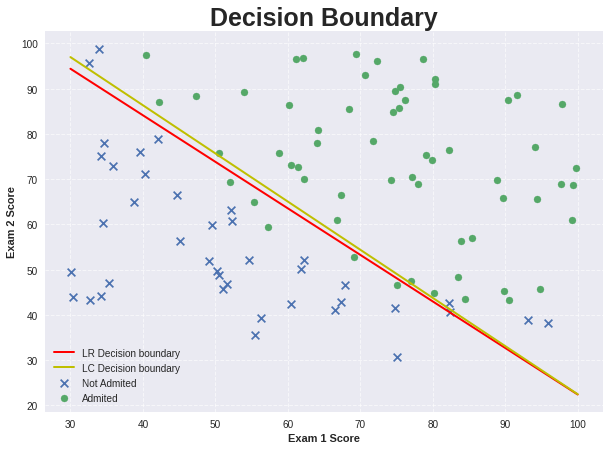

In [ ]:
# Plot decision boundary
boundary = lambda theta, x: (- theta[0] / theta[1] * (x - x_mu[0]) / x_std[0] - theta[2] / theta[1]) * x_std[1] + x_mu[1]

# Plot the dataset
plt.figure(figsize=(10, 7))
plt.title('Decision Boundary', fontweight='bold', fontsize=25)
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y[i] == 0], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y[i] == 0], 
            label='Not Admited', s=60, marker='x')
plt.scatter([x_i[0] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            [x_i[1] for i, x_i in enumerate(x_raw) if y[i] == 1], 
            label='Admited')
plt.plot(np.linspace(30, 100, 100), boundary(theta_lr, np.linspace(30, 100, 100)), 
         c='r', lw=2, label='LR Decision boundary')
plt.plot(np.linspace(30, 100, 100), boundary(theta_lc, np.linspace(30, 100, 100)), 
         c='y', lw=2, label='LC Decision boundary')
plt.grid(True, alpha=0.6, zorder=0, ls='--')
plt.xlabel('Exam 1 Score', fontweight='bold')
plt.ylabel('Exam 2 Score', fontweight='bold')
plt.legend()
plt.show()

# Additional 1
Try out different learning rates on the Linear Classification problem to converge quickly. Choose different values of the learning rate on a log-scale.

# Additional 2
Try out different learning rates on the Logistic Regression problem to converge quickly. Choose different values of the learning rate on a log-scale.

# Additional 3
Try to add a set of outliers (~5 data points) and compare linear classification and Logistic Regression.